<div class="alert alert-block alert-success">
    <h1 style="margin-bottom:0.5cm"><b>LAB 7: Statistics</b></h1>
    <p style="margin-bottom:0.25cm">Course 240317: <b>Data Analysis in Rehabilitation</b>
    <br>
        Master in Neuroengineering and Rehabilitation</p>
    <b>Prof. Joan F. Alonso</b>
    <br>
    <br>
</div>

<div class="alert alert-block alert-info">
    <p>In this lab session, we will:</p>
    <ul>
        <li><b>Learn about several useful tests (ETC: 60 min)</b></li>
            <ul>
                <li>Outlier detection based on Z scores and learning models</li>
                <li>Hypothesis testing</li>
                <ul>
                    <li>Normality</li>
                    <li>Relationship between categorical variables</li>
                    <li>Sample means (ANOVA)</li>
                </ul>
            </ul>
        <li><b>Practise with these tests (ETC: 90 min)</b></li>
            <ul>
                <li>Checking the outlier detection</li>
                <li>Using different tests for normality</li>
                <li>Assessing the relationship between categorical features and the outcome in the stroke dataset</li>
                <li>Using the ANOVA F-score to perform feature selection</li>
            </ul>
    </ul>
</div>

<div class="alert alert-block alert-warning">
    <p style="text-align: center">Before starting, remember to add <samp>statsmodel</samp> to the <samp>conda</samp> enviroment:</p>
    <p style="text-align: center"><samp>conda activate data_analysis</samp></p>
    <p style="text-align: center"><samp>conda install statsmodels</samp></p>
</div>

# Statistics with  Python

In this lab session we will put some statistical tools to work, as they can be of great help before actually training any learning model. 

There are many statistical tools and tests we can use during exploratory data analysis to get to know or data by checking trends, distribution and other characteristics, and also those who will help us clean the data or reduce the dimensionality of the problem in front of us.

## Outlier detection

Let's start with **blood volume pulse recordings (BVP)**. The BVP is widely used as a method of measuring the heart rate and it is embedded in lots of heart rate  monitoring gadgets and apps.

<img align="left" src="https://s3-us-west-2.amazonaws.com/courses-images-archive-read-only/wp-content/uploads/sites/403/2015/05/21032046/Screen-Shot-2015-05-21-at-10.47.45-AM.png" width=700 >

The BVP measures heart rate based on the volume of blood that passes through the tissues in a localised area with each heartbeat.  Wherever there is easy access to a pulse there is a potential measurement site, but usually the pads of the fingers or the earlobes are commonly used. Measurements are commonly obtained by a photoplethysmography sensor that measures changes in blood volume in the arteries and capillaries.

The raw BVP pattern is influenced by
- the recording location
- the heart’s left ventricular ejection
- the elasticity/stiffness of the aorta and arteries

Whereas **the ECG signal is usually more precise**, it requires a more **complicated setup** and it is **obtrusive compared to applying a BVP sensor** (no gel, tape or adhesives, or placement on the chest). However, this ease of use comes with an increased **sensitivity to motion artifact**s.

And this is what we have in our data file `240NR024-07-bvp_outliers`, so let's load the modules we are going to use and the data:

In [1]:
import pandas as pd
import numpy as np  # from numpy import array, histogram, mean, std, ptp, hstack
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path


SOURCE_PATH = Path().resolve()
DATA_PATH = SOURCE_PATH / "Data"
OUTPUT_PATH = SOURCE_PATH / "Output"
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)


bvp = pd.read_csv(DATA_PATH / "240317-07-bvp-outliers.csv")
bvp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29850 entries, 0 to 29849
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BVP (mV)  29850 non-null  float64
dtypes: float64(1)
memory usage: 233.3 KB


We have only one column. Let's add the time ($F_s=1\,kHz$) and plot everything:

In [2]:
bvp.insert(0, 'time (s)', np.arange(0, len(bvp))/1000)
bvp.head()

,time (s),BVP (mV)
0,0.000,4.371176
1,0.001,4.381662
2,0.002,4.392143
3,0.003,4.402620
4,0.004,4.413092


Let's display the signals and highlight the segments that we consider outliers. At this point, it's merely a visual assessment!

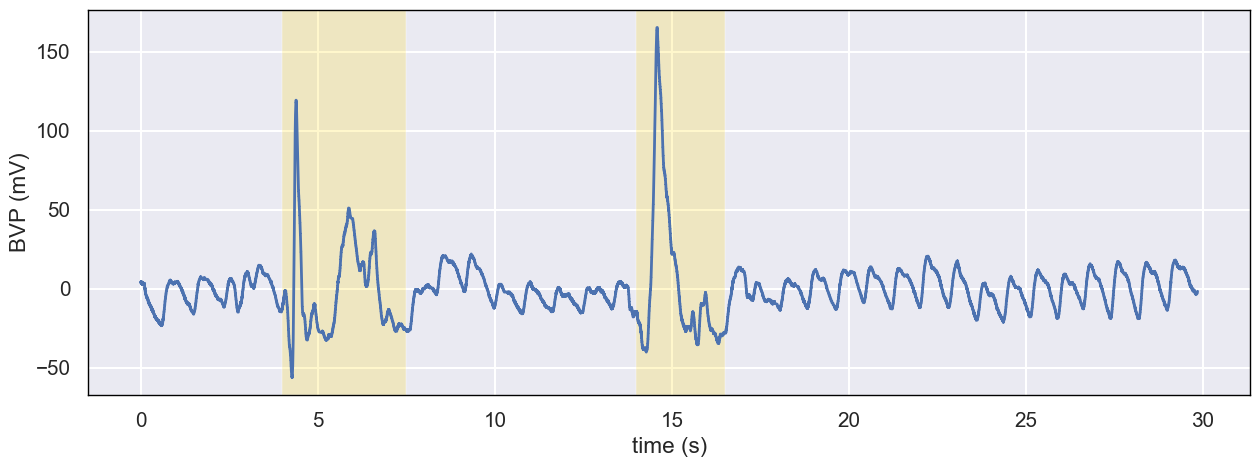

In [3]:
sns.set(context="talk",
        font_scale=0.9,
        style="darkgrid",
        rc={'lines.linewidth': 2,
            'axes.linewidth': 1,
            'axes.edgecolor': 'black',
            'axes.axisbelow': True,
            'savefig.dpi': 600,
            })

fig1, ax1 = plt.subplots(figsize=(15, 5))
sns.lineplot(x=bvp['time (s)'], y=bvp['BVP (mV)'], ax=ax1)
plt.axvspan(4.0, 7.5, facecolor='gold', alpha=0.2)
plt.axvspan(14.0, 16.5, facecolor='gold', alpha=0.2);

### Statistical Approach

Statistically, outliers correspond to the events that have a lower probability of happening.

We can plot the histogram of the signal and try to identify them, but in this case only the points that are deviated from the mean will be considered outliers:

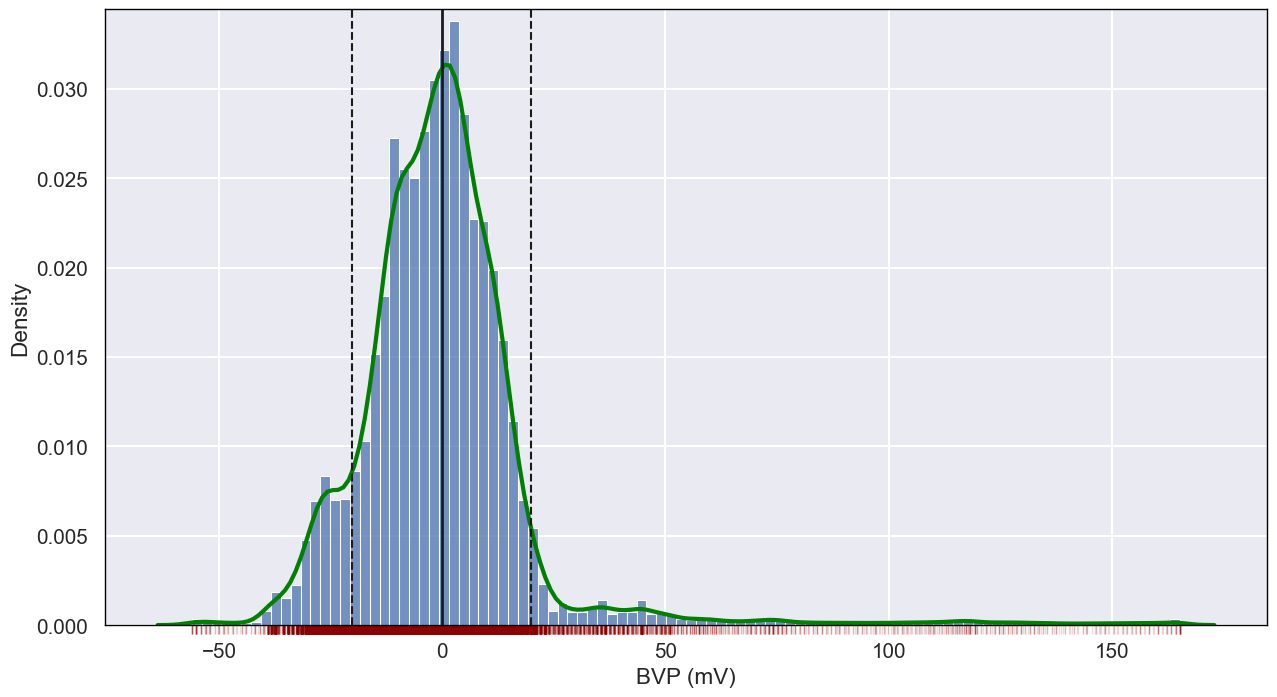

In [4]:
mean_bvp = np.mean(bvp['BVP (mV)'])
std_bvp = np.std(bvp['BVP (mV)'])

fig2, ax2 = plt.subplots(figsize=(15, 8))
sns.histplot(ax=ax2, data=bvp, x='BVP (mV)', bins=100, stat='density')
sns.kdeplot(ax=ax2, data=bvp, x='BVP (mV)', color='green', linewidth=3)
sns.rugplot(ax=ax2, data=bvp, x='BVP (mV)', height=-.015,
            clip_on=False, color='darkred', alpha=0.15)
plt.axvline(mean_bvp+std_bvp, color='k', linestyle='dashed', linewidth=1.5)
plt.axvline(mean_bvp-std_bvp, color='k', linestyle='dashed', linewidth=1.5)
plt.axvline(mean_bvp, color='k', linewidth=2);

The histogram shows the distribution of values of the signal. The black vertical line corresponds to the mean value and the dashed lines to the standard deviation relative to the mean. One approach could be to consider all values below or above the range of the standard deviation (or two standard deviations) as outliers.

A standard way of plotting univariate data to check for outliers is the well-known boxplot, that can be done [directly in pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html) or using the fancier [seaborn].(https://seaborn.pydata.org/generated/seaborn.boxplot.html)

<div class="alert alert-block alert-info">
Other similar kinds of plots can be produced taking into account the median or the mode of the distribution, and percentiles and quartiles instead of standard deviation (see some Python examples <a href="https://stackoverflow.com/questions/63307440/how-to-plot-a-mean-line-on-a-distplot-between-0-and-the-y-value-of-the-mean">here</a>).
</div>

Checking the values chosen as outliers and comparing it to the signal plot we made before will be our (very easy) [Exercise 1](#Exercise-1.-Checking-the-statistical-approach).

### Unsupervised ML approach

Given our knowledge about learning algorithms, let's try another approach:
1. First, we will segment our signal, for example in 0.5 s segments.
1. After that, we extract signals from each segment that may separate outliers from the useful values of the signals. To keep the exercise simple, we will use only 2 features (standard deviation and kurtosis, for example), but anything can be useful: peak-to-peak amplitude, max slope, average value, number of peaks, number of zero crossings...
1. Next, plot the features and assess if outliers appear more sparsely than the others (a scatter plot, for example)
1. The, apply some clustering technique than detects outliers automatically (DBSCAN, [1-class SVM](https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html#sphx-glr-auto-examples-svm-plot-oneclass-py), etc). We must remember to standardise the data before fitting the model.
1. Finally, check if the points that have been identified as outliers correspond to the segments identified visually at the beginning of this notebook.

The code corresponding to steps 1 and 2 is as follows:

In [5]:
bvp_signal = bvp['BVP (mV)'].to_numpy()
Fs = 1000  # sampling frequency (Hz)
seg_time = 0.5  # segment time (s)

seg_long = int(seg_time*Fs)  # number of samples per segment
num_seg = int(len(bvp)/seg_long)  # number of segments
if len(bvp) % seg_long:
    num_seg += 1

# feature vectors
bvp_seg_std = np.zeros((num_seg, 1))
bvp_seg_kur = np.zeros((num_seg, 1))

# feature calculation
pos = 0
for seg in range(num_seg):
    signal_segment = bvp_signal[pos:pos+seg_long]
    # bvp_seg_std(seg, 1) =
    # bvp_seg_kur(seg, 1) =
    pos += seg_long

The remaining steps are part of the [Exercise 2](#Exercise-2.-Checking-the-clustering-approach). Remember to comment on the results and compare them to the trivial statistical approach of [Exercise 1](#Exercise-1.-Checking-the-statistical-approach).

## Hypothesis Testing

In statistics, when we wish to start asking questions about the data and interpret the results, we use statistical methods that provide a confidence or likelihood about the answers. In general, this class of methods is called statistical hypothesis testing, or significance tests.

There are literally dozens (if not hundreds) of tests we can use for hypothesis testing. It would take years to explain, understand and apply them all!

Here we will practise with some of them that can be useful in data analysis and machine learning, for example:
- A test that assumes that data has a normal distribution.
- A test that assumes that two samples were drawn from the same underlying population distribution.
- A test to check if there is a statistically significant relationship between categorical variables

So, without further ado, let's go!

### Normality testing
Remember the two features of the HFO dataset? We had to log-transform them to reduce the skewness of the distribution we saw in the exploratory analysis.

Let's load the data again and check the normality of `freq` in patient `PAT_1` (`amp` is so asymmetric that even after log-transforming will not be close to a Gaussian):

In [6]:
from scipy.stats import shapiro, normaltest, anderson, kstest 

random_state = 42
hfo = pd.read_csv(DATA_PATH / '240317-06-hfo.csv')

# Copy 'PAT_1' data into new dataframe & obtain 'logfreq'
patient_data = hfo[hfo['id']=='PAT_1'].copy()
patient_data['logfreq'] = np.log10(patient_data['freq'])

Here we can use the [Shapiro-Wilk test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html) (suitable for samples with less than a few thousands of observations), the [Anderson-Darling test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html) or the more sophisticated [Kolmogorov-Smirnov test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html) (which can also be used to check if two samples come from the same underlying distribution).

Check the links to the official documentation to know how to call each function. Here's an example:

Shapiro-Wilk Test of freqs (H0: the sample has a Gaussian distribution)

    stat = 0.989379
    pval = 0.000001



Shapiro-Wilk Test of log fregs

    stat = 0.997116
    pval = 0.069243



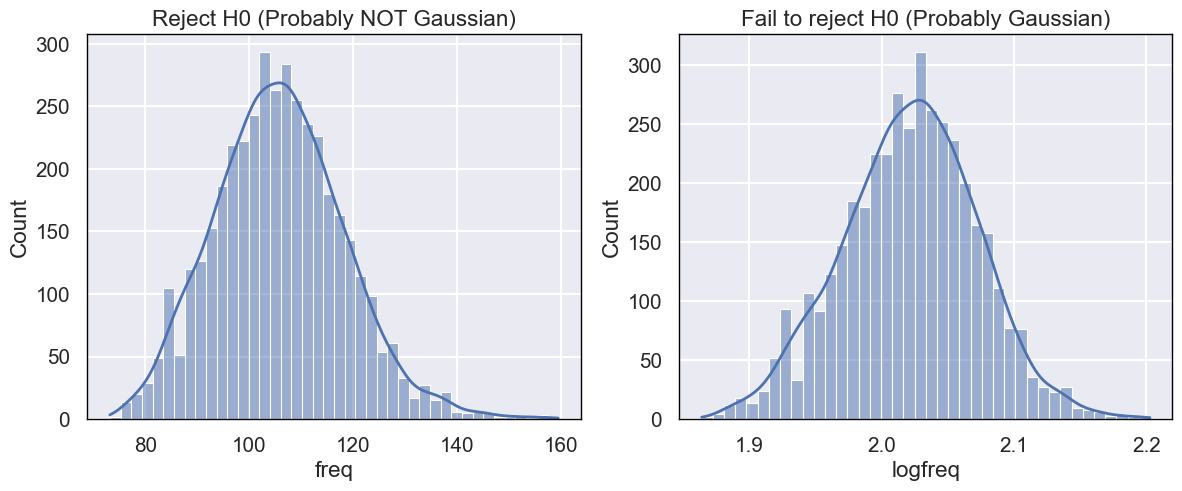

In [7]:
# Test 'freq' for normality (we use only 1000 values)
s, p = shapiro(patient_data['freq'].sample(1000, random_state=random_state))
print("Shapiro-Wilk Test of freqs (H0: the sample has a Gaussian distribution)\n")
print(f"    stat = {s:0.6f}\n    pval = {p:0.6f}\n")
if p > 0.05:
    txt0 = "Fail to reject H0 (Probably Gaussian)"
else:
    txt0 = "Reject H0 (Probably NOT Gaussian)"

s, p = shapiro(patient_data['logfreq'].sample(1000, random_state=random_state))
print("\n\nShapiro-Wilk Test of log fregs\n")
print(f"    stat = {s:0.6f}\n    pval = {p:0.6f}\n")
if p > 0.05:
    txt1 = "Fail to reject H0 (Probably Gaussian)"
else:
    txt1 = "Reject H0 (Probably NOT Gaussian)"

# Plot both histograms to check for any visual differences
fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.histplot(ax=ax3[0], data=patient_data['freq'], kde=True);
ax3[0].title.set_text(txt0)
sns.histplot(ax=ax3[1], data=patient_data['logfreq'], kde=True);
ax3[1].title.set_text(txt1)

In [Exercise 3](#Exercise-3.-Use-different-normality-tests) there is some work related to these tests.

## Statistical relationship between categorical variables
The Chi-squared test of independence determines whether there is a statistically significant relationship between categorical variables. In other words, it answers the question: _Do the values of one categorical variable depend on the value of other categorical variables?_

The null hypothesis states that there are no relationships between the categorical variables, that is, knowing the value of one variable does not help us predict the value of another variable.

**Quick example**

If you are a Star Trek fan (if you are not, you are missing one of the greatest sci-fi of all time) you already know about the different colored uniforms. In the original TV series, Captain Kirk and the crew wear different colored uniforms to identify the crewmember’s work area. Those who wear red shirts have the unfortunate reputation of dying more often than those who wear gold or blue shirts.

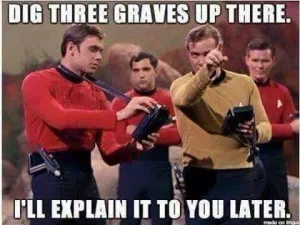

Let's use the Chi Square test to determine whether wearing the dreaded red shirt in Star Trek is the kiss of death! We need to use this test because these variables are both categorical variables:
 - Shirt color can be only blue, gold, or red.
 - Fatalities can be only dead or alive.

| Color | Areas | Crew | Fatalities |
| :- | :- | :-: | :-: | 
| Blue | Science and Medical | 136 | 7 |
| Gold | Command and Helm | 55 | 9 |
| Red | Operations, Engineering, and Security | 239 | 24 |
| All | All | 430 | 40 |

The Chi-Squared test assumes (the null hypothesis) that the observed frequencies for a categorical variable match the expected frequencies for the categorical variable. The Chi-Squared test does this for a contingency table, first calculating the expected frequencies for the groups, then determining whether the division of the groups, called the observed frequencies, matches the expected frequencies.

So first, let's load the (already-prepared) contingency table:

In [8]:
st = pd.read_csv(DATA_PATH / '240317-07-star-trek.csv', index_col=0)
st

,Blue,Gold,Red,Total
Dead,7,9,24,40
Alive,129,46,215,390


And perform the test (we do not include the `Total` column):

In [9]:
from scipy.stats import chi2_contingency


c, p, dof, expected = chi2_contingency(st[['Blue', 'Gold', 'Red']])
print(f"    stat = {c:0.6f}\n    pval = {p:0.6f}\n    dof  = {dof}\n")
pd.DataFrame(expected, columns=['Blue', 'Gold', 'Red'], index=['Expected Dead', 'Expected Alive'])

    stat = 6.188615
    pval = 0.045306
    dof  = 2



,Blue,Gold,Red
Expected Dead,12.651163,5.116279,22.232558
Expected Alive,123.348837,49.883721,216.767442


Expected values are obtained considering the variables (_survival_ and _shirt color_) as independent (independence is the null hypothesis, after all). For example: $P(dead \cap blue) = P(dead)\cdot P(blue) = \frac{40}{430}\cdot\tfrac{136}{430} = 0.029421$, which corresponds to 12.65 out of 430 people.


**The p-value is lower than 0.05**, we can reject the null hypothesis and conclude that there is a relationship between shirt color and deaths. Blue has a value lower than expected, gold a higher value, and red is very close to the expected value.

**The Chi-square test indicates that red shirts do not die more frequently than expected. This tells us that is vital to include the genuinely pertinent variables in the analysis!**

Now imagine that _survival_ is the outcome variable of a **classification problem**. **Should we include _shirt_color_ as a feature?**
- When variables are independent, their counts are very close to the expected values. 
- High Chi-Squared values (or equivalently, low p-values) indicate dependence between feature and outcome and **therefore we should include it as a feature!**
- And when one-hot encoding colors, probably we could remove the red one, as it is the one closest to the expected value.

## N-way ANOVA
An analysis of variance test, or ANOVA, can be thought of as a generalization of the t-tests for more than 2 groups. The independent t-test is used to compare the means of a condition between two groups. ANOVA is used when we want to compare the means of a condition between more than two groups.

ANOVA tests if there is a difference in the mean somewhere in the model (testing if there was an overall effect), but it does not tell us where the difference is (if there is one). To find where the difference is between the groups, we have to conduct post-hoc tests.

To perform any tests, we first need to define the null and alternate hypothesis:
- Null Hypothesis – There is no significant difference among the groups
- Alternate Hypothesis – There is a significant difference among the groups

Basically, ANOVA is performed by comparing two types of variation, the variation between the sample means, as well as the variation within each of the samples. The result of the ANOVA formula, the F statistic (also called the F-ratio), allows for the analysis of multiple groups of data to determine the variability between samples and within samples.

There are certain assumptions we need to make before performing ANOVA:
- The observations are obtained independently and randomly from the population defined by the factor levels
- The data for each factor level is normally distributed
- Independence of cases: the sample cases should be independent of each other
- Homogeneity of variance: Homogeneity means that the variance among the groups should be approximately equal

**Quick example**
We will use an example dataset from the `statmodel` package. A study was designed to determine the optimal operating conditions of a manufacturing process to maximize yield. The study assessed temperature settings, chemical supply companies, and two mixing methods.

**Let's go then!**

In [10]:
import statsmodels.api as sm


manuf = sm.datasets.webuse('manuf')
print(manuf.info())
manuf[::5]

HTTPError: HTTP Error 403: Forbidden

Let's make a 3-way ANOVA. The official documentation for conducting an ANOVA with `statsmodel` can be found [here](https://www.statsmodels.org/stable/anova.html).

<div class="alert alert-block alert-warning">
    <p>Type 3 sum of squares is what is typically desired and is the default output for SPSS, SAS, and Stata.</p>
    <p>To get type 3 sum of squares we must specify <code style="background: transparent">", Sum"</code> in the formula for the factors. Without specifying this, only Type I and Type II sum of squares will be calculated correctly.</p>
    <p>We must also use  <code style="background: transparent">C()</code> if variables are categorical.

In [ ]:
from statsmodels.formula.api import ols
manuf["Yield"] = manuf["yield"]  # for some reason, test outcome must have first letter capitalized
model = ols("Yield ~ C(temperature, Sum) * C(chemical, Sum) * C(method, Sum)", data=manuf).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
aov_table

The interaction between temperature, chemical type, and method is statistically non-significant (p-value 0.7785). This indicates that different level combinations of the factors do not produce a significant difference in the yield.

**Thus this term should be removed from the ANOVA model and re-ran looking at the 2-factor interactions:**

In [ ]:
model = ols("Yield ~ C(temperature, Sum) + C(chemical, Sum) + C(method, Sum) + " +
            "C(temperature, Sum):C(chemical, Sum) + C(temperature, Sum):C(method, Sum) + " +
            "C(chemical, Sum):C(method, Sum)", data=manuf).fit()
print(model.summary())

The only 2-factor interaction that is statistically significant is between temperature and method, the other 2-factor interactions should be removed and the model needs to be re-ran.

In [ ]:
model = ols("Yield ~ C(temperature, Sum) * + C(method, Sum) + C(chemical, Sum)", data=manuf).fit()
print(model.summary())
sm.stats.anova_lm(model, typ=3)

The sum of squares that each factor accounted for did not change while removing non-significant factors from the model due to the nature of Type III sum of squares. The information that did change are the F-statistics and their respective p-values, as well as the residual sum of squares and the residual degrees of freedom.

### Interpretation of the results
The overall interaction between the three factors was statistically non-significant, $F(2, 24.0) = 0.2530$, $p-value = 0.7785$

After looking at the reduced model which included all possible 2-factor interactions, the only significant interaction was between temperature and method. The non-significant interactions were removed and the final model showed that temperature and method have a statistically significant interaction effect on yield, $F(2, 29) = 6.5315$, $p-value = 0.0045$.


### Assumption check & post-hoc testing
To see how to check the assumptions using an ANOVA model we can [check this page](https://www.pythonfordatascience.org/anova-python#assumption_check), for example. For a more in-depth look at the assumptions and some potential remedies, please [check out this page](https://www.pythonfordatascience.org/parametric-assumptions-python).

To see how to conduct post-hoc testing, please refer to [this page](https://www.pythonfordatascience.org/anova-python#post-hoc). 

Before conducting post-hoc testing it should be noted that an easy way to test for group difference of the interaction term using `statmodel` is to create a column in the data frame which represents the possible group combinations of the significant interaction term and use this instead of trying to use a `groupby` object.

A quick demonstration is below, but still refer to the page mentioned above for a more in-depth demonstration:

In [ ]:
import statsmodels.stats.multicomp as mc

interaction_groups = "Temp_" + manuf.temperature.astype(str) + " & " + "Method_" + manuf.method.astype(str)

comp = mc.MultiComparison(manuf["Yield"], interaction_groups)
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

Understanding how the ANOVA works will help understand how feature selection can be performed using the F-statistic. 

<div class="alert alert-block alert-warning">
    <p><b>IMPORTANT!!</b> An ANOVA with a binary response violates the assumptions of normality of the residuals. In this case a generalized linear model (binary logistic regression) would be more appropriate, for example.</p>
</div>

<div class="alert alert-block alert-info">
    <p> However, we can use the ANOVA F-value (it is a popular feature selection tecnique) already implemented in <code style="background: transparent">sklearn</code>.</p>
        <p>For example, the function <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html"><code style="background: transparent">f_classif</code></a> computes the ANOVA F-value for classification problems with continous features, and the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html"><code style="background: transparent">chi2</code></a> for categorical features. The function <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html"><code style="background: transparent">mutual_info_classif</code></a>can work with both types of features.</p>
    <br>
    <p><b>Check the examples of <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html"><code style="background: transparent">SelectKBest</code></a> function</b> to know how to use this univariate feature selection!</p>
</div>

<br>
<br>
<div class="alert alert-block alert-success", style="border-radius: 70px">
    <h1 style="text-align: center; margin-left:4cm; margin-top:0.5cm; margin-bottom:0.5cm; font-size:48px">Exercises</h1>
</div>
<br>
<div>
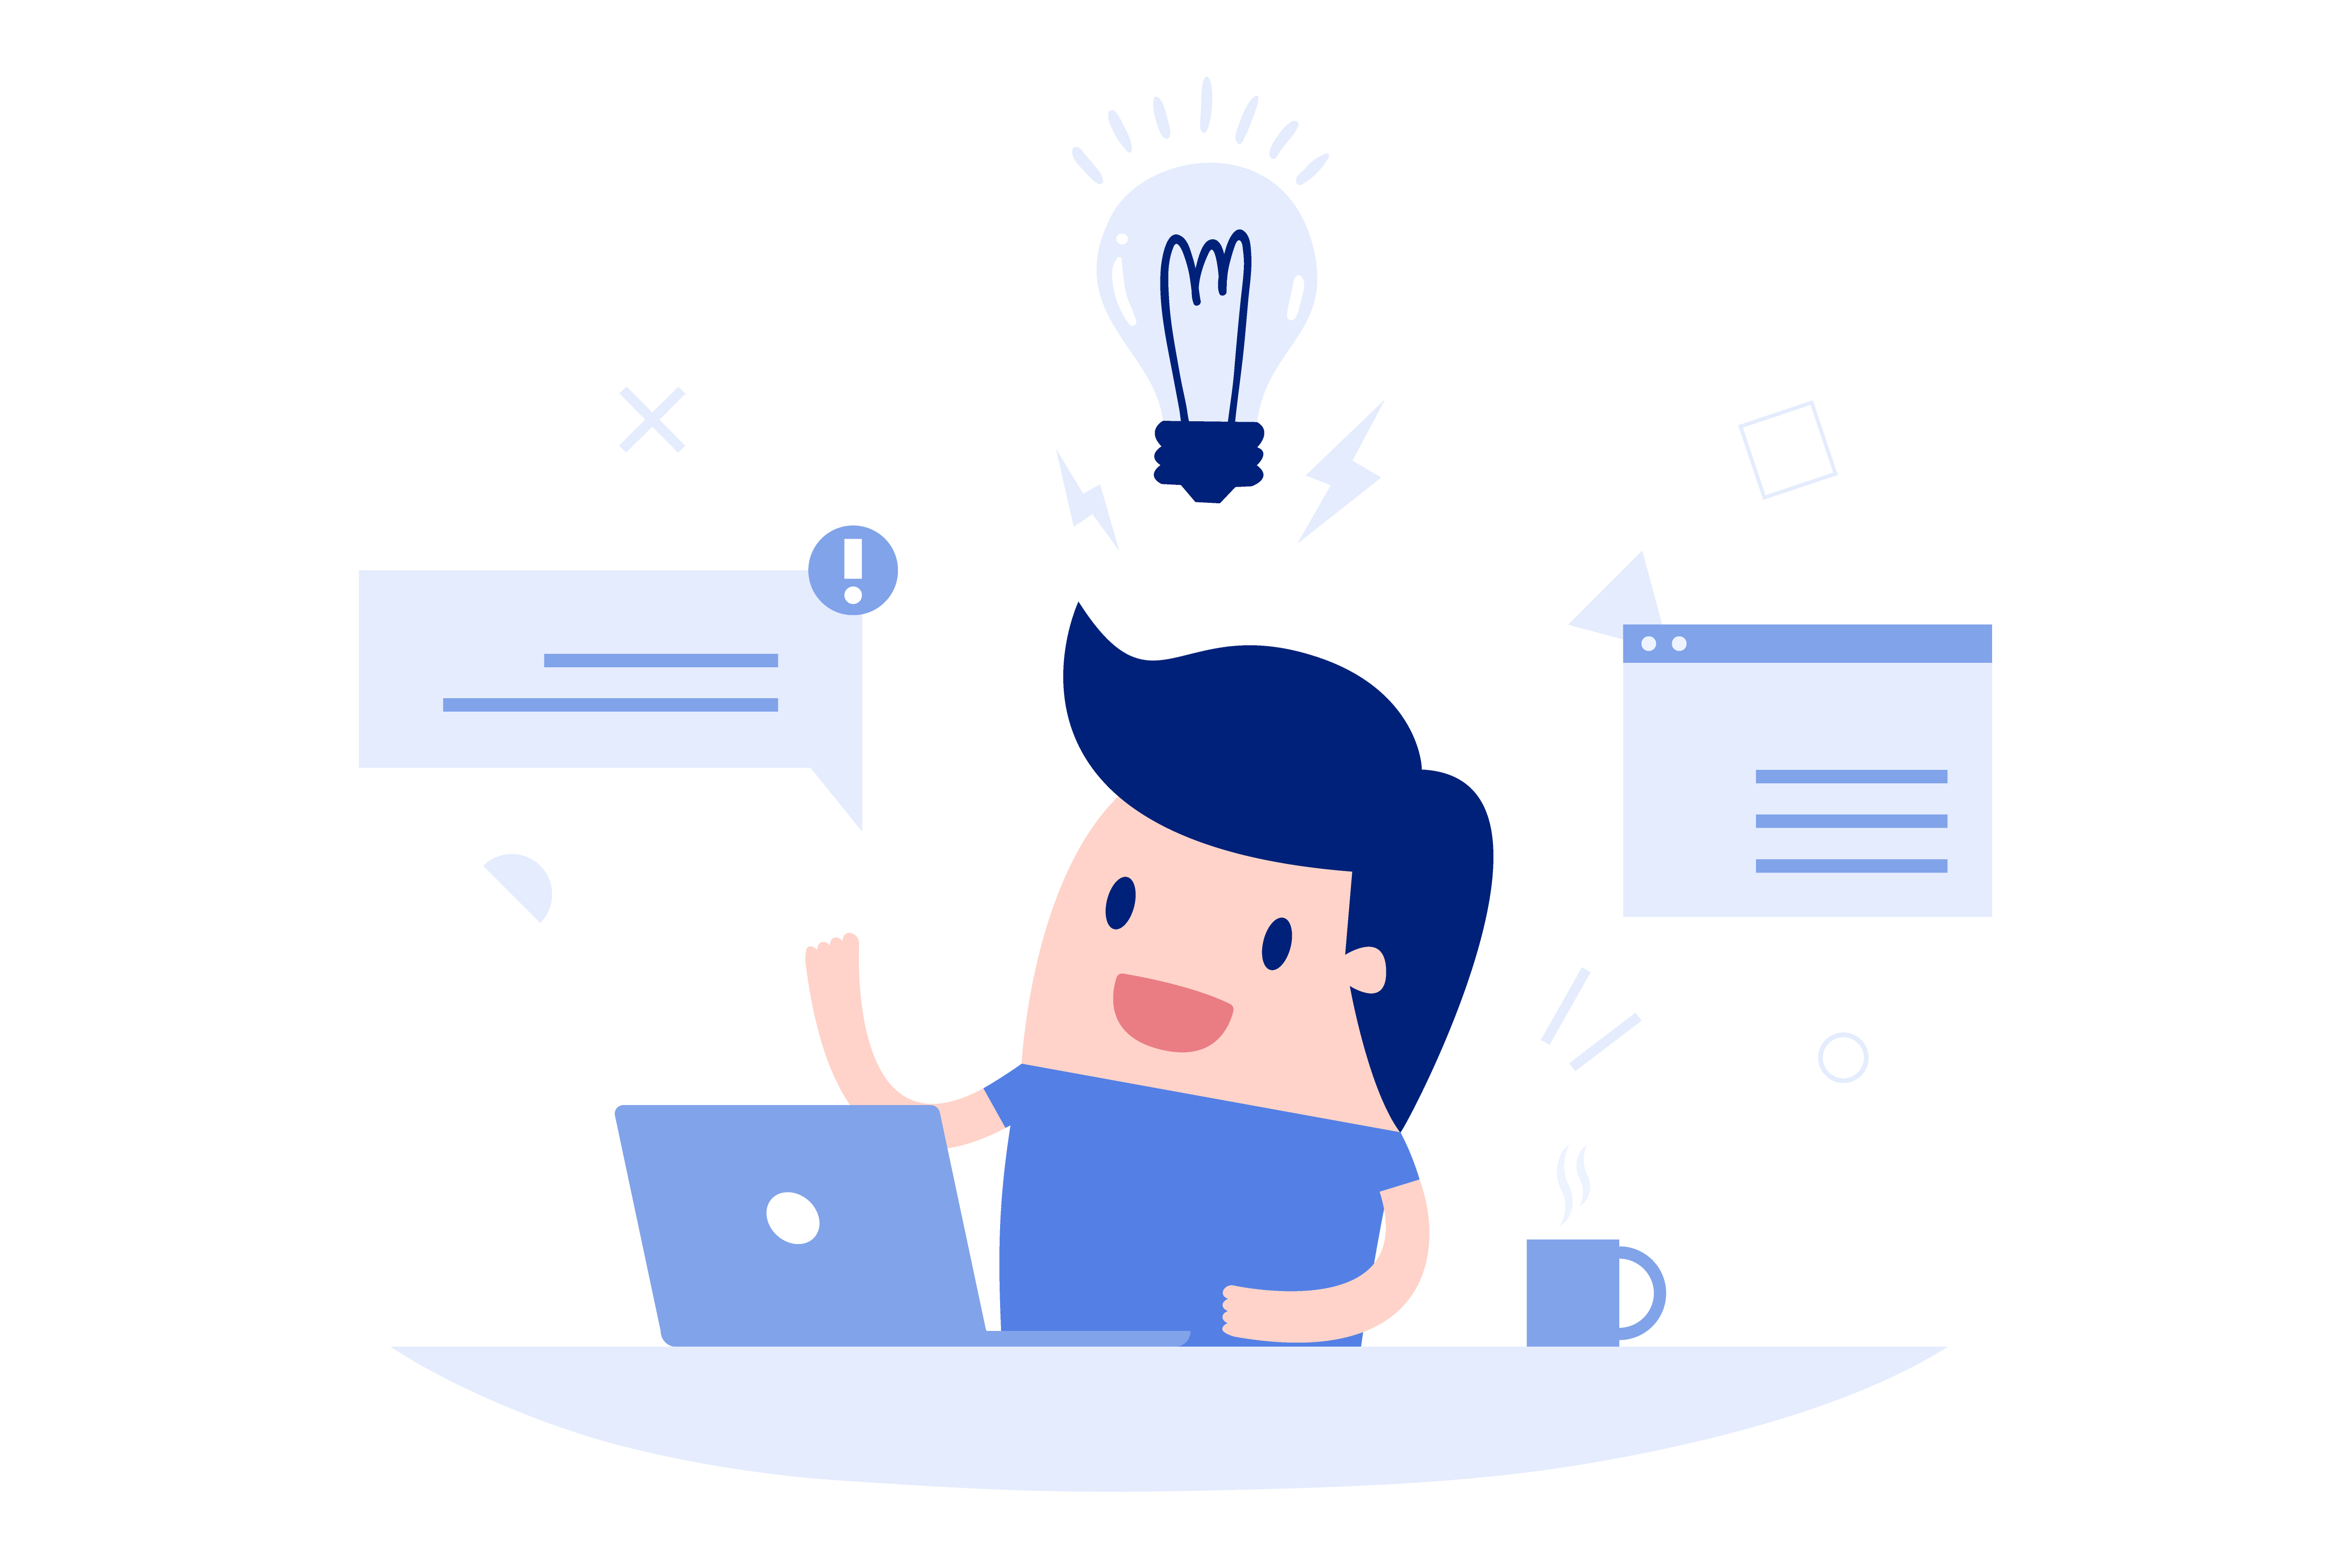
</div>

<h2 style="margin-top:0.5cm; margin-bottom:0.5cm; color: green">Exercise 1. Checking the statistical approach</h2>

**To complete this exercise:**
1. Plot the BVP signal along time and some horizontal lines depicting the $mean\pm2\cdot stdev$ to check the segments that can be considered outliers. 
1. Comment on the results by comparing the identified artifacts with the plot in [the outlier detection section](#Outlier-detection)

In [11]:
import pandas as pd
import numpy as np  # from numpy import array, histogram, mean, std, ptp, hstack
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path


SOURCE_PATH = Path().resolve()
DATA_PATH = SOURCE_PATH / "Data"
OUTPUT_PATH = SOURCE_PATH / "Output"
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)


bvp = pd.read_csv(DATA_PATH / "240317-07-bvp-outliers.csv")
bvp.info()


bvp.insert(0, 'time (s)', np.arange(0, len(bvp))/1000)
bvp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29850 entries, 0 to 29849
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BVP (mV)  29850 non-null  float64
dtypes: float64(1)
memory usage: 233.3 KB


,time (s),BVP (mV)
0,0.000,4.371176
1,0.001,4.381662
2,0.002,4.392143
3,0.003,4.402620
4,0.004,4.413092


In [12]:
mean_BVP = bvp['BVP (mV)'].mean()
std_BVP = bvp['BVP (mV)'].std()

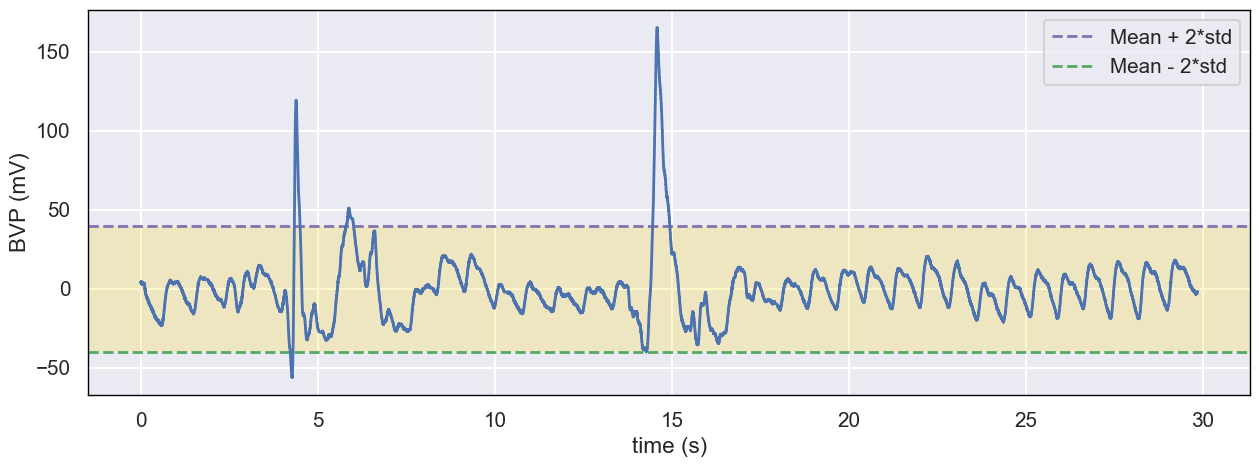

In [13]:
sns.set(context="talk",
        font_scale=0.9,
        style="darkgrid",
        rc={'lines.linewidth': 2,
            'axes.linewidth': 1,
            'axes.edgecolor': 'black',
            'axes.axisbelow': True,
            'savefig.dpi': 600,
            })

fig1, ax1 = plt.subplots(figsize=(15, 5))

# Plot horizontal lines at mean plus and minus 2 standard deviations
plt.axhline(y=mean_BVP + 2 * std_BVP, color='m', linestyle='--', label='Mean + 2*std')
plt.axhline(y=mean_BVP - 2 * std_BVP, color='g', linestyle='--', label='Mean - 2*std')

sns.lineplot(x=bvp['time (s)'], y=bvp['BVP (mV)'], ax=ax1)
plt.axhspan(ymin=mean_BVP-2*std_BVP, ymax=mean_BVP+2*std_BVP, facecolor='gold', alpha=0.2)

<hr style="margin-top:0.5cm; margin-bottom:0.5cm; border-top: 9px double #BBDDBB; background-color: #FFF"></hr>
<h2 style="margin-top:0.5cm; margin-bottom:0.5cm; color: green">Exercise 2. Checking the clustering approach</h2>


**As explained above, to complete this exercise:**
- Plot the features and assess if outliers appear more sparsely than the others (a scatter plot, for example)
- Apply some clustering technique than detects outliers automatically (DBSCAN, 1-class SVM, etc). We must remember to standardise the data before fitting the model.
- Finally, check if the points that have been identified as outliers correspond to the segments identified visually at the beginning of this notebook.

<div class="alert alert-block alert-info">
    <p>I you are in the mood, you can try calculating different characteristics in addition to kurtosis and standard deviation</p>
</div>  

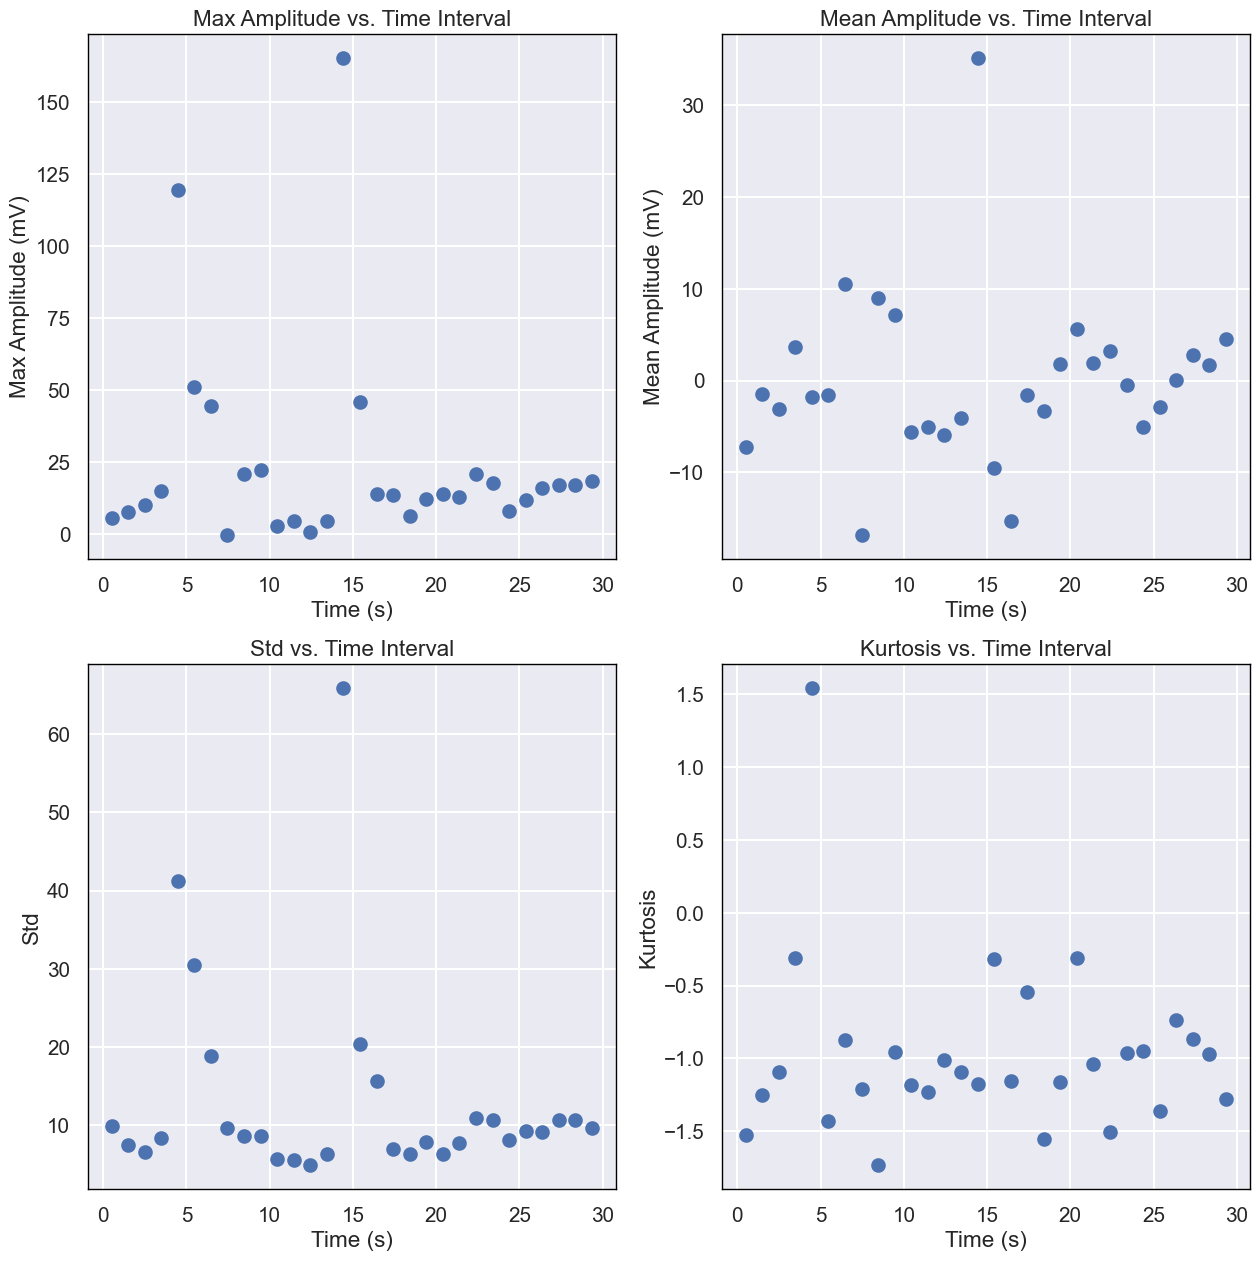

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis

# Define the time intervals
interval_size = 1
total_duration = 30
num_intervals = int(total_duration / interval_size)
intervals = [(i * interval_size, (i + 1) * interval_size) for i in range(num_intervals)]

# Extract time and BVP data
time_data = bvp['time (s)']
bvp_data = bvp['BVP (mV)']

# Group the data by time intervals
interval_bins = np.linspace(time_data.min(), time_data.max(), num_intervals + 1)
bvp['interval'] = pd.cut(time_data, bins=interval_bins, right=False)
grouped = bvp.groupby('interval')

# Calculate the max amplitude and the mean amplitude for each group
max_amplitudes = grouped['BVP (mV)'].max()
mean_bpv = grouped['BVP (mV)'].mean()
std_bpv = grouped['BVP (mV)'].std()
kurtosis_bpv = grouped['BVP (mV)'].apply(kurtosis)

# Create a new DataFrame with the calculated max amplitude and mean amplitude
features_per_segment = pd.DataFrame({
    'Time Interval': interval_bins[:-1] + np.diff(interval_bins) / 2,
    'Max Amplitude (mV)': max_amplitudes.values,
    'Mean Amplitude (mV)': mean_bpv.values,
    'Std' : std_bpv.values,
    'Kurtosis': kurtosis_bpv.values
})

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Plot the scatter plot for max amplitude
axes[0, 0].scatter(features_per_segment['Time Interval'], features_per_segment['Max Amplitude (mV)'])
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Max Amplitude (mV)')
axes[0, 0].set_title('Max Amplitude vs. Time Interval')

# Plot the scatter plot for mean amplitude
axes[0, 1].scatter(features_per_segment['Time Interval'], features_per_segment['Mean Amplitude (mV)'])
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Mean Amplitude (mV)')
axes[0, 1].set_title('Mean Amplitude vs. Time Interval')

# Plot the scatter plot for std
axes[1, 0].scatter(features_per_segment['Time Interval'], features_per_segment['Std'])
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Std')
axes[1, 0].set_title('Std vs. Time Interval')

# Plot the scatter plot for Kurtosis
axes[1, 1].scatter(features_per_segment['Time Interval'], features_per_segment['Kurtosis'])
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_ylabel('Kurtosis')
axes[1, 1].set_title('Kurtosis vs. Time Interval')

plt.show()

The features that we decided to extract are the following ones:
- *Max Amplitude (mV)*: This feature represents the maximum amplitude of the BVP signal within each time interval.
- *Mean Amplitude (mV)*: This feature represents the mean (average) amplitude of the BVP signal within each time interval. It provides a measure of the central tendency of the signal within the interval, giving an overall sense of its intensity or magnitude.
- *Std (Standard Deviation)*: This feature represents the standard deviation of the BVP signal within each time interval. It quantifies the dispersion or variability of the signal around its mean value within the interval. A higher standard deviation indicates greater variability in the signal amplitude.
- *Kurtosis*: This feature represents the kurtosis of the BVP signal within each time interval. Kurtosis measures the peakedness or tail heaviness of the distribution of values. A positive kurtosis indicates a peaked distribution with heavy tails, while a negative kurtosis indicates a flat distribution. In the context of the BVP signal, kurtosis may provide insights into the shape of the signal's amplitude distribution within the interval, potentially indicating the presence of sharp peaks or outliers.

### Clustering

#### Standardization

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
# Standardize the data
# Without kurtosis
columns_to_standardize = ['Max Amplitude (mV)','Mean Amplitude (mV)', 'Std']
data_to_standardize = features_per_segment[columns_to_standardize]

scaler = StandardScaler()
features_standardized = scaler.fit_transform(data_to_standardize)

# With kurtosis
columns_to_standardize_k = ['Max Amplitude (mV)','Mean Amplitude (mV)', 'Std', 'Kurtosis']
data_to_standardize_k = features_per_segment[columns_to_standardize_k]

scaler_k = StandardScaler()
features_standardized_k = scaler_k.fit_transform(data_to_standardize_k)

#### Outliers plot function

In [17]:
# outliers plot function
def outliers_plot(ax, features_df, outliers, model='', extra_feature=''):
    scatter = ax.scatter(range(len(features_df)), features_df.mean(1), c=outliers, cmap='viridis')
    ax.set_xlabel('Index')
    ax.set_ylabel('Mean standardized features') # to provide max representation of the interval
    ax.set_title(model + ' Outlier Detection ' + extra_feature)
    plt.colorbar(scatter, ax=ax, label='Cluster Label')
    ax.axvspan(4.0, 7.5, facecolor='gold', alpha=0.2)
    ax.axvspan(14.0, 16.5, facecolor='gold', alpha=0.2)

#### Density-based algorithms

Density-based clustering algorithms, like DBSCAN and OPTICS, group data points into clusters based on the density of the data at any given location. They connect high-density areas into clusters, allowing for the detection of arbitrary-shaped distributions in the data.

DBSCAN, the most well-known density-based algorithm, is effective in identifying clusters of varying shapes and sizes. OPTICS improves upon DBSCAN by enhancing its sensitivity to parameters such as neighborhood radius and the minimum number of points required for clustering. mean-shift, another density-based clustering algorithm, can be computationally expensive due to the use of kernel functions.

These algorithms are particularly useful when dealing with noisy data or when the resulting clusters can exhibit arbitrary shapes. One notable advantage of density-based clustering algorithms is their efficiency and suitability for data with arbitrary shapes. Additionally, by design, they do not assign outliers to clusters, focusing solely on identifying dense regions in the data.

**DBSCAN**

In [18]:
from sklearn.cluster import DBSCAN

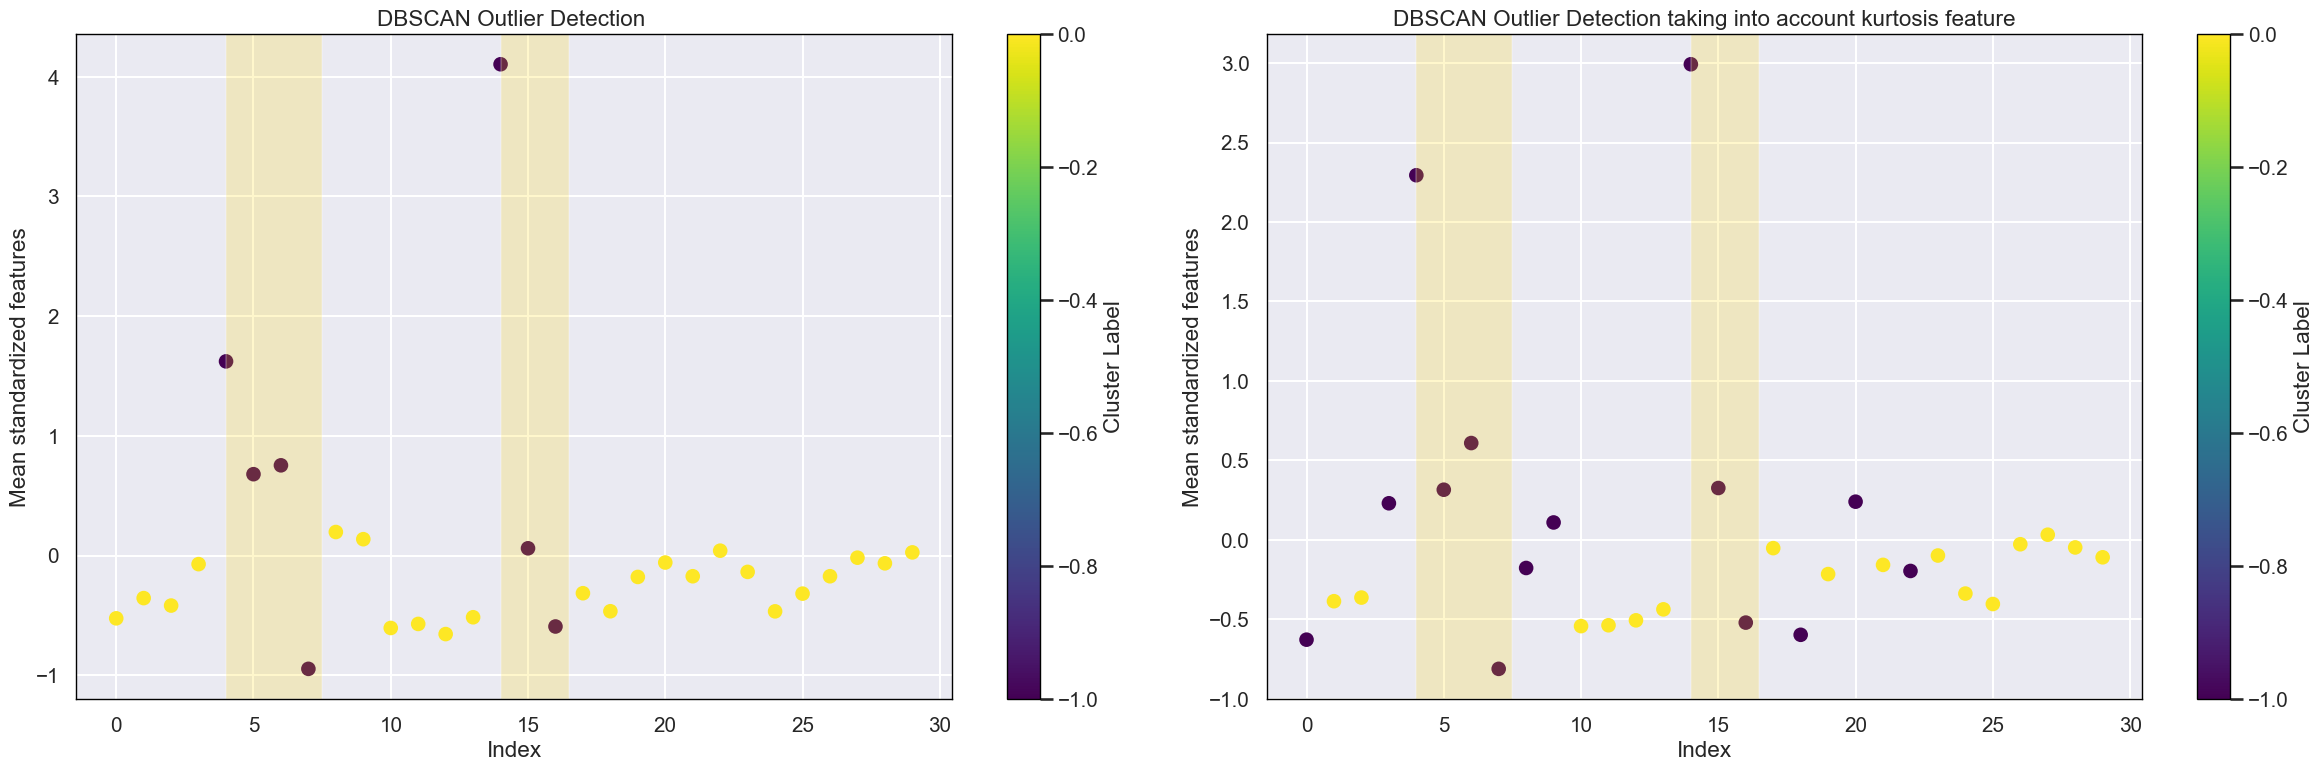

In [19]:
## Apply DBSCAN clustering
# Without kurtosis
dbscan = DBSCAN(eps=0.5, min_samples=5)
outliers = dbscan.fit_predict(features_standardized)

# With kurtosis
dbscan_k = DBSCAN(eps=0.5, min_samples=5)
outliers_k = dbscan_k.fit_predict(features_standardized_k)

#
## Visualization
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# Visualize the clusters without taking into account kurtosis feature
outliers_plot(axes[0], features_standardized, outliers, 'DBSCAN')

# Visualize the clusters taking into account kurtosis feature
outliers_plot(axes[1], features_standardized_k, outliers_k, 'DBSCAN', 'taking into account kurtosis feature')

# Adjust layout and display
plt.tight_layout()
plt.show()

**OPTICS**

In [20]:
from sklearn.cluster import OPTICS

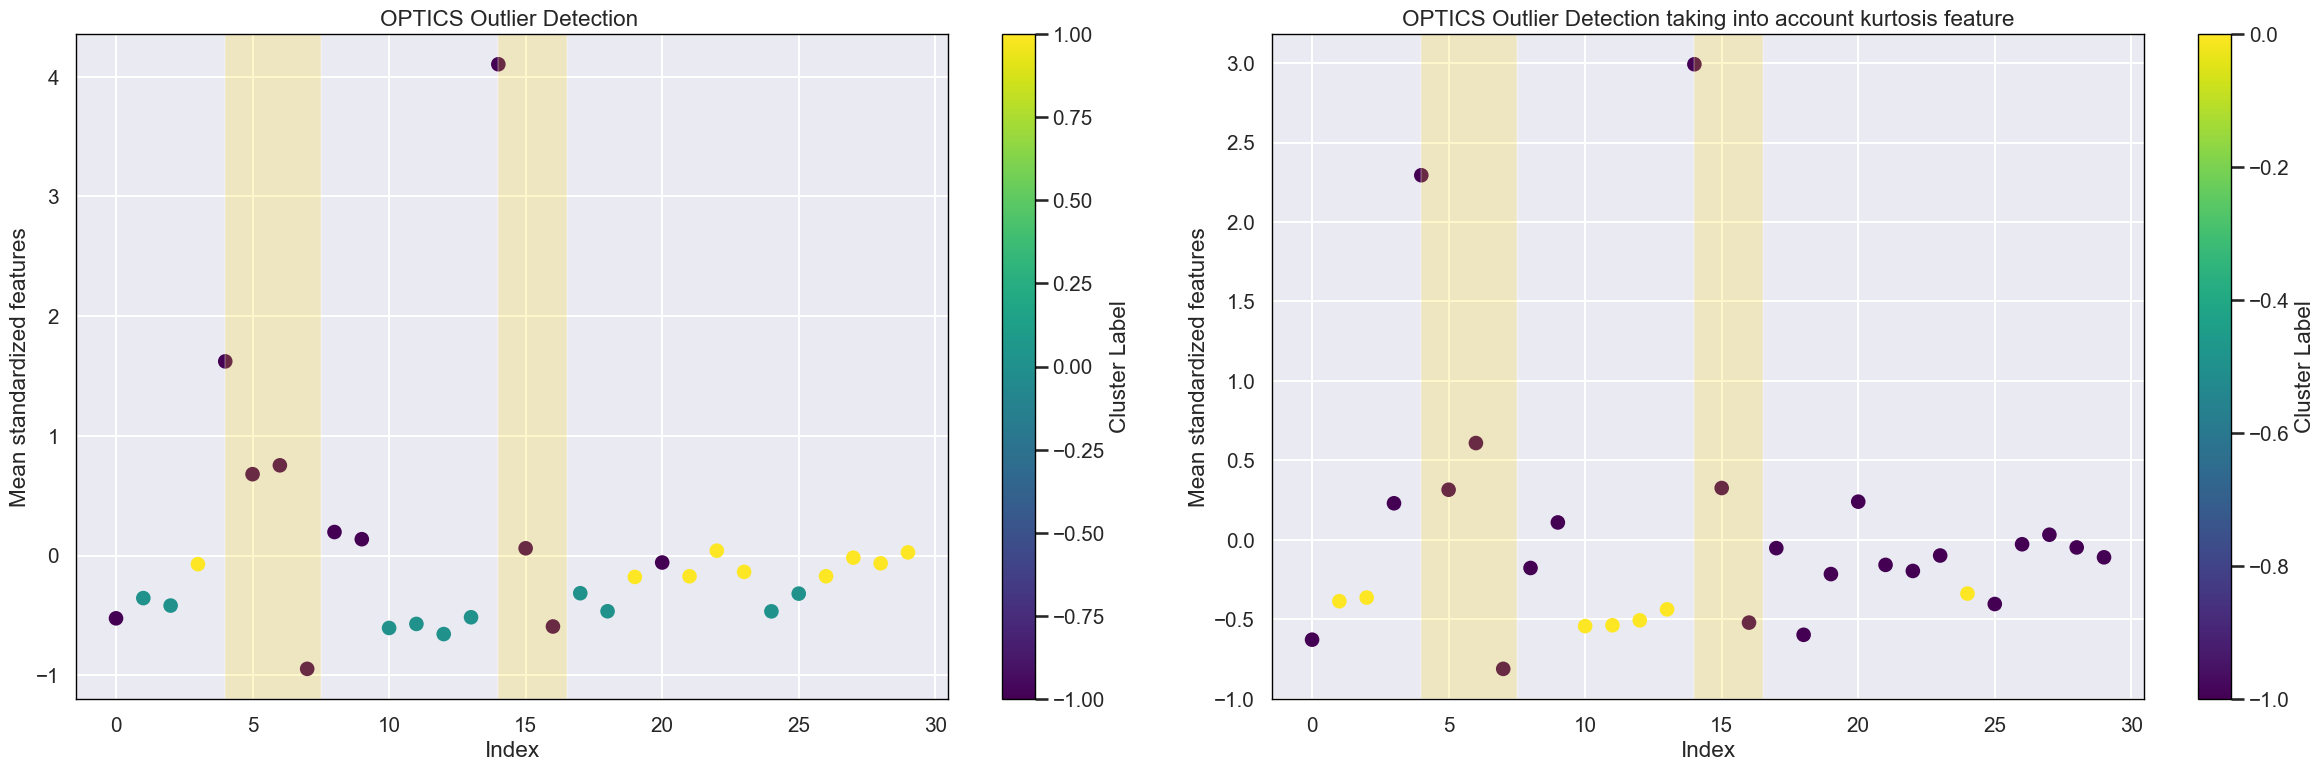

In [21]:
# Perform OPTICS Clustering
# Without kurtosis
optics = OPTICS(min_samples=5)
optics.fit(features_standardized)
labels = optics.labels_

# With kurtosis
optics_k = OPTICS(min_samples=5)
optics_k.fit(features_standardized_k)
labels_k = optics_k.labels_

#
## Visualization
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# Visualize the clusters without taking into account kurtosis feature
outliers_plot(axes[0], features_standardized, labels, 'OPTICS')

# Visualize the clusters taking into account kurtosis feature
outliers_plot(axes[1], features_standardized_k, labels_k, 'OPTICS', 'taking into account kurtosis feature')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Extract outliers (data points labeled as -1 by OPTICS)
outliers_indices = np.where(labels == -1)[0]
outliers = features_standardized[outliers_indices]

#### Comment results

In all scatter plots can be seen that the the points that correspond to the segments identified visually as outliers at the beginning of this notebook are identified as outliers too. However, it is exposed a difference between both algorithms. 

Firstly, comparing the scatter plots that take into account kurtosis feature with the ones that not it can be seen that so much extra points are identified as outliers. This could be because some clustering algorithms, such as DBSCAN or OPTICS, may use distance-based metrics or density-based approaches to identify outliers. When we include kurtosis as a feature, it alters the data distribution and can affect how these algorithms perceive data density and cluster boundaries. As a result, points that were previously considered within clusters may now be identified as outliers due to changes in the data distribution caused by the kurtosis feature.

Secondly, analysing the scatter plot that does not take into account kurtosis feature of both algorithms, it is shown that while the DBSCAN algorithm identifies as outliers only the points that correspond to the segments identified at the beginning of this notebook, the OPTICS algorithm identifies also as outliers some extra points that do not correspond to the segments. This could be due to diverse facts: 

- *Parameter Sensitivity*: OPTICS has fewer parameters to tune compared to DBSCAN, but the choice of the min_samples parameter can significantly impact the clustering results.
- *Data Characteristics*: OPTICS may struggle with datasets of varying densities or complex shapes, potentially leading to the misidentification of outliers. DBSCAN's fixed distance threshold may offer better handling of such datasets.
- *Noise Handling*: DBSCAN explicitly labels noise points, providing more control over outlier detection. OPTICS identifies outliers based on reachability distances, which may result in a higher number of outliers, some of which may not be real.
- *Algorithm Behavior*: OPTICS constructs a reachability plot capturing the density-based clustering structure, which can introduce additional complexity compared to DBSCAN. The ordering of points based on reachability distances in OPTICS may lead to different clustering results, particularly in datasets with complex structures.

<hr style="margin-top:0.5cm; margin-bottom:0.5cm; border-top: 9px double #BBDDBB; background-color: #FFF"></hr>
<h2 style="margin-top:0.5cm; margin-bottom:0.5cm; color: green">Exercise 3. Use different normality tests</h2>


**To complete this exercise:**
1. Check the normality of HFO data (`freq` and `logfreq`, for example) with different tests.
1. Try another dataset, for example `240317-04-weight-height.csv`, and check the normality of some features.
1. Comment on the results.

<div class="alert alert-block alert-warning">
    <p>The results may vary depending on the test, <b>try different patients and different number of samples.</b></p>
    <p>HFO data were not very Gaussian, even after log-transforming, according to the 2D scatter plots of the previous session. The sophisticated tests can show us this with less data points.</p>
</div>

### HFO

In [22]:
hfo_all = pd.read_csv(DATA_PATH / '240317-06-hfo.csv')
hfo = hfo_all[hfo_all['id']=='PAT_1'].copy()
hfo['log_freq']=np.log10(hfo['freq'])
hfo.head()

,id,ch,soz,amp,freq,log_freq
0,PAT_1,A1,No,36.885938,89.475728,1.951705
1,PAT_1,A2,No,39.005931,112.432432,2.050892
2,PAT_1,A2,No,32.280395,96.463768,1.984364
3,PAT_1,A2,No,34.247650,122.152284,2.086902
4,PAT_1,A3,No,18.786685,85.333333,1.931119


Shapiro-Wilk Test - Frequency Data:
Statistics=0.989, p=0.000
Freq: Sample does not look Gaussian (reject H0)

Shapiro-Wilk Test - Log Frequency Data:
Statistics=0.997, p=0.069
Log freq: Sample looks Gaussian (fail to reject H0)



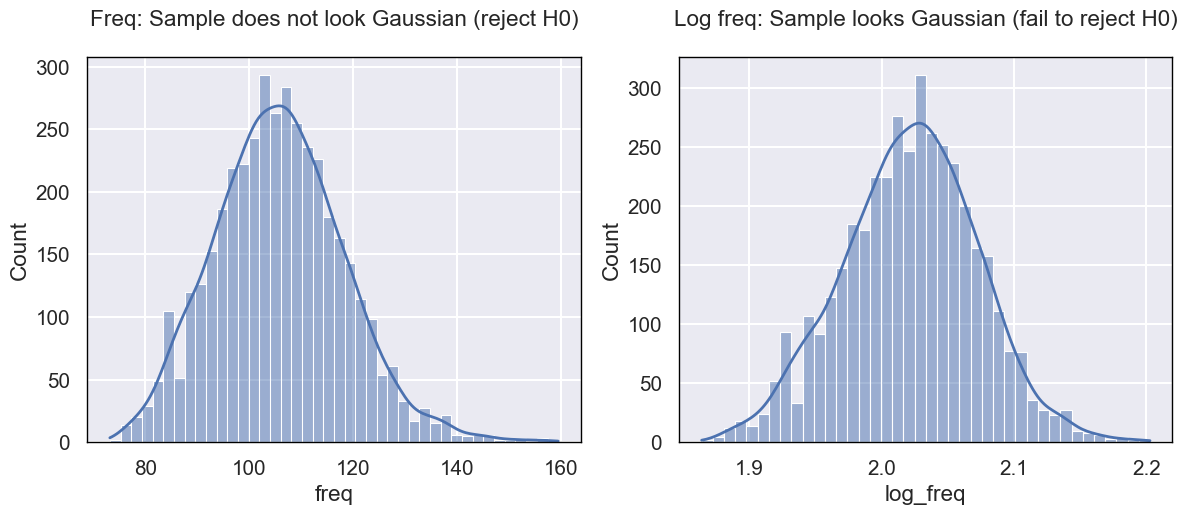

In [23]:
from scipy.stats import shapiro
# Perform Shapiro-Wilk test for frequency data:
stat, p = shapiro(hfo['freq'].sample(1000, random_state=random_state))

# Print the results
print('Shapiro-Wilk Test - Frequency Data:')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    txt0='Freq: Sample looks Gaussian (fail to reject H0)\n'
    print(txt0)
else:
    txt0='Freq: Sample does not look Gaussian (reject H0)\n'
    print(txt0)
    
    
# Perform Shapiro-Wilk test for log frequency data:
stat_log, p_log = shapiro(hfo['log_freq'].sample(1000, random_state=random_state))
# Print the results
print('Shapiro-Wilk Test - Log Frequency Data:')
print('Statistics=%.3f, p=%.3f' % (stat_log, p_log))
    
if p_log > alpha:
    txt1='Log freq: Sample looks Gaussian (fail to reject H0)\n'
    print(txt1)
else:
    txt1='Log freq: Sample does not look Gaussian (reject H0)'
    print(txt1)
# Plot both histograms to check for any visual differences

fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.histplot(ax=ax3[0], data=hfo['freq'], kde=True);
ax3[0].title.set_text(txt0)
sns.histplot(ax=ax3[1], data=hfo['log_freq'], kde=True);
ax3[1].title.set_text(txt1)


In [24]:
from scipy.stats import normaltest

# Perform D'Agostino's K^2 test for frequency data: D'Agostino's K^2 Test: This test computes skewness and kurtosis to determine if the data distribution departs from normality.
stat, p = normaltest(hfo['freq'])

# Print the results
print("D'Agostino's K^2 Test - Frequency Data:")
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    txt0='Freq: Sample looks Gaussian (fail to reject H0)\n'
    print(txt0)
else:
    txt0='Freq: Sample does not look Gaussian (reject H0)\n'
    print(txt0)
    
    
# Perform D'Agostino's K^2 test for frequency data: D'Agostino's K^2 Test: This test computes skewness and kurtosis to determine if the data distribution departs from normality.
stat_log, p_log = normaltest(hfo['log_freq'])

# Print the results
print("D'Agostino's K^2 Test - Log Frequency Data:")
print('Statistics=%.3f, p=%.3f' % (stat_log, p_log))
if p_log > alpha:
    txt1='Log freq: Sample looks Gaussian (fail to reject H0)\n'
    print(txt1)
else:
    txt1='Log freq: Sample does not look Gaussian (reject H0)\n'
    print(txt1)



D'Agostino's K^2 Test - Frequency Data:
Statistics=81.268, p=0.000
Freq: Sample does not look Gaussian (reject H0)

D'Agostino's K^2 Test - Log Frequency Data:
Statistics=1.020, p=0.600
Log freq: Sample looks Gaussian (fail to reject H0)



In [25]:
from scipy.stats import anderson

# Perform Anderson-Darling test for frequency data: This test is based on the Anderson-Darling statistic, which combines measures of skewness and kurtosis.
result = anderson(hfo['freq'])

# Print the results
print('Anderson-Darling Test - Frequency Data:')
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
        
        
        
# Perform Anderson-Darling test for log frequency data: This test is based on the Anderson-Darling statistic, which combines measures of skewness and kurtosis.

result_log = anderson(hfo['log_freq'])

print('\nAnderson-Darling Test - Log Frequency Data:')
print('Statistic: %.3f' % result_log.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl_log, cv_log = result_log.significance_level[i], result_log.critical_values[i]
    if result_log.statistic < result_log.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl_log, cv_log))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl_log, cv_log))


Anderson-Darling Test - Frequency Data:
Statistic: 2.924
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)

Anderson-Darling Test - Log Frequency Data:
Statistic: 1.761
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


In [26]:
from scipy.stats import kstest

stat, p = kstest(hfo['freq'], "norm", alternative='less')

print("Ks test - Frequency Data:")
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    txt0='Freq: Sample looks Gaussian (fail to reject H0)\n'
    print(txt0)
else:
    txt0='Freq: Sample does not look Gaussian (reject H0)\n'
    print(txt0)
    

stat_log, p_log = kstest(hfo['log_freq'], "norm", alternative='two-sided')

print("Ks test - Log Frequency Data:")
print('Statistics=%.3f, p=%.3f' % (stat_log, p_log))

if p_log > alpha:
    txt0='Freq: Sample looks Gaussian (fail to reject H0)\n'
    print(txt0)
else:
    txt0='Freq: Sample does not look Gaussian (reject H0)\n'
    print(txt0)


Ks test - Frequency Data:
Statistics=1.000, p=0.000
Freq: Sample does not look Gaussian (reject H0)

Ks test - Log Frequency Data:
Statistics=0.969, p=0.000
Freq: Sample does not look Gaussian (reject H0)



### Weight- Height

In [27]:
weigh_height = pd.read_csv(DATA_PATH / '240317-04-weight-height.csv')
weigh_height.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [28]:
from scipy.stats import shapiro
# Perform Shapiro-Wilk test for frequency data: This test is commonly used to check for normality. It tests the null hypothesis that a sample comes from a normally distributed population.
stat, p = shapiro(weigh_height['Height'])

# Print the results
print('Shapiro-Wilk Test - Heigh Data:')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Shapiro-Wilk Test - Heigh Data:
Statistics=0.996, p=0.000
Sample does not look Gaussian (reject H0)


C:\Users\Ferran\anaconda3\envs\data_analysis\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [29]:
from scipy.stats import normaltest

# Perform D'Agostino's K^2 test for log-frequency data: D'Agostino's K^2 Test: This test computes skewness and kurtosis to determine if the data distribution departs from normality.
stat, p = normaltest(weigh_height['Height'])

# Print the results
print("D'Agostino's K^2 Test - Height Data:")
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

D'Agostino's K^2 Test - Height Data:
Statistics=169.419, p=0.000
Sample does not look Gaussian (reject H0)


In [30]:
from scipy.stats import anderson

# Perform Anderson-Darling test for frequency data: This test is based on the Anderson-Darling statistic, which combines measures of skewness and kurtosis.
result = anderson(weigh_height['Weight'])

# Print the results
print('Anderson-Darling Test - Weight:')
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Anderson-Darling Test - Weight:
Statistic: 48.253
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


### Comment results

<hr style="margin-top:0.5cm; margin-bottom:0.5cm; border-top: 9px double #BBDDBB; background-color: #FFF"></hr>
<h2 style="margin-top:0.5cm; margin-bottom:0.5cm; color: green">Exercise 4. Chi-Squared</h2>

Go back and load the `240317-05-stroke.xlsx` dataset and check if any of the categorical variables show dependence with the selected outcome (5 or 10 points increase in RAVLT075 score). Elaborate your response according to the test values obtained.

You can also use [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) with [chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) if you prefer, but the results should be the same as using the Chi-Squared test between each categorical feature and the categorical outcome.

<div class="alert alert-block alert-info">
    <p>There is an easy way of building contingency tables in <code style="background-color:transparent">pandas</code>, check the <a href=""><code style="background-color:transparent">crosstab</code></a> function</p>
</div>    
<div class="alert alert-block alert-warning">
    <p><b>Remember!</b> There is no incorrect answer to this exercise, take it as an exploratory analysis of the dataset, the classification results depend on a lot of factors and a Chi-Squared analysis can guide us a bit, but it's not something we have to follow blindly.</p>
</div>

In [31]:
stroke = pd.read_excel(DATA_PATH / '240317-05-stroke.xlsx')
stroke.head()


,ID,NTASKS,LOS,D2H,AGE1,AGE2,SEX,MSTAT,PO,SPO,...,DIGMEM,RAVLT0751,RAVLT0151,RAVLT015R1,RAVLT0752,RAVLT0152,RAVLT015R2,FEPMR2,IMP_RAVLT075,IMP_GT5
0,4554810,248,132.131829,30.533576,43.117808,43.201462,MALE,SG,7.0,5.0,...,5.0,49.0,11.0,14.0,9.0,11.0,14.0,40.0,-40,NO
1,4240782,181,73.966840,19.768275,55.534247,55.588406,FEMALE,MR,7.0,5.0,...,4.0,37.0,7.0,15.0,NaN,NaN,NaN,NaN,-37,NO
2,4428684,49,36.917766,18.744595,55.446575,55.497930,MALE,MR,7.0,5.0,...,4.0,31.0,1.0,0.0,NaN,NaN,NaN,NaN,-31,NO
3,4946760,57,35.243981,56.540139,49.728767,49.883672,FEMALE,SG,7.0,5.0,...,4.0,51.0,14.0,14.0,35.0,10.0,13.0,29.0,-16,NO
4,5564754,75,68.989340,39.662928,34.819178,34.927844,FEMALE,SG,7.0,5.0,...,5.0,56.0,13.0,15.0,42.0,8.0,13.0,48.0,-14,NO


In [32]:
from scipy.stats import chi2_contingency

def construct_categorical_df(df,feature,feature_opts,outcome,outcome_opts,index):
    
    feature_yes=[]
    feature_no=[]
    feat_list=[]
        
    for l in range(len(feature_opts)):
        feature_yes.append([])
        feature_no.append([])
        
    dt={}
    
    for i in range(0,len(df)):
        for j in range(0,len(feature_opts)):
            if stroke[feature][i]==feature_opts[j]:                
                if stroke[outcome][i]==outcome_opts[0]:
                    feature_yes[j].append(stroke[outcome][i])
                else:
                    feature_no[j].append(stroke[outcome][i])
                    
    for k in range(0,len(feature_opts)):
        if len(feature_yes[k])>=5 and len(feature_no[k])>=5:
            dt[feature_opts[k]]=[len(feature_yes[k]),len(feature_no[k])]
            feat_list.append(feature_opts[k])
            
            
    new_pd=pd.DataFrame(data=dt,index=index) 
    return(new_pd,feat_list)

### **GENDER**

In [33]:
stroke_sex,feat_list=construct_categorical_df(stroke,'SEX',['FEMALE','MALE'],'IMP_GT5',['YES','NO'],index=['IMP_GT5', 'IMP_LT5'])
stroke_sex

,FEMALE,MALE
IMP_GT5,47,92
IMP_LT5,48,110


In [34]:
c, p, dof, expected = chi2_contingency(stroke_sex[feat_list])
print(f"    stat = {c:0.6f}\n    pval = {p:0.6f}\n    dof  = {dof}\n")
pd.DataFrame(expected, columns=['FEMALE', 'MALE'], index=['Expected IMP_GT5', 'Expected IMP_LT5'])

    stat = 0.258367
    pval = 0.611244
    dof  = 1



,FEMALE,MALE
Expected IMP_GT5,44.461279,94.538721
Expected IMP_LT5,50.538721,107.461279


### **MARITAL STATUS**

In [35]:
stroke_MS,feat_list=construct_categorical_df(stroke,'MSTAT',['SG','MR','DI','WI'],'IMP_GT5',['YES','NO'],index=['IMP_GT5', 'IMP_LT5'])
stroke_MS

c, p, dof, expected = chi2_contingency(stroke_MS[feat_list])
print(f"    stat = {c:0.6f}\n    pval = {p:0.6f}\n    dof  = {dof}\n")
pd.DataFrame(expected, columns=feat_list, index=['Expected IMP_GT5', 'Expected IMP_LT5'])

    stat = 1.397580
    pval = 0.497186
    dof  = 2



,SG,MR,DI
Expected IMP_GT5,30.559701,87.447761,7.992537
Expected IMP_LT5,34.440299,98.552239,9.007463


### **AGE WHEN STROKE**

In [36]:
labels = ["{0} - {1}".format(i, i + 5) for i in range(10, 90, 5)]
stroke["age_group"] = pd.cut(stroke['AGE1'], range(10, 95, 5), right=False, labels=labels)

stroke_age,feat_list=construct_categorical_df(stroke,'age_group',labels,'IMP_GT5',['YES','NO'],index=['IMP_GT5', 'IMP_LT5'])
stroke_age

,35 - 40,40 - 45,45 - 50,50 - 55,55 - 60,60 - 65
IMP_GT5,11,25,26,26,30,8
IMP_LT5,5,14,25,44,37,12


In [37]:
c, p, dof, expected = chi2_contingency(stroke_age[feat_list])
print(f"    stat = {c:0.6f}\n    pval = {p:0.6f}\n    dof  = {dof}\n")
pd.DataFrame(expected, columns=feat_list, index=['Expected IMP_GT5', 'Expected IMP_LT5'])

    stat = 11.091413
    pval = 0.049597
    dof  = 5



,35 - 40,40 - 45,45 - 50,50 - 55,55 - 60,60 - 65
Expected IMP_GT5,7.665399,18.684411,24.43346,33.536122,32.098859,9.581749
Expected IMP_LT5,8.334601,20.315589,26.56654,36.463878,34.901141,10.418251


### **AGE WHEN COGNITIVE ASSESSMENT**

In [38]:
labels = ["{0} - {1}".format(i, i + 4) for i in range(10, 90, 5)]
stroke["age_group2"] = pd.cut(stroke['AGE2'], range(10, 95, 5), right=False, labels=labels)

stroke_age2,feat_list=construct_categorical_df(stroke,'age_group2',labels,'IMP_GT5',['YES','NO'],index=['IMP_GT5', 'IMP_LT5'])
stroke_age2

,35 - 39,40 - 44,45 - 49,50 - 54,55 - 59,60 - 64
IMP_GT5,11,25,26,25,31,8
IMP_LT5,5,14,25,43,36,13


In [39]:
c, p, dof, expected = chi2_contingency(stroke_age2[feat_list])
print(f"    stat = {c:0.6f}\n    pval = {p:0.6f}\n    dof  = {dof}\n")
pd.DataFrame(expected, columns=feat_list, index=['Expected IMP_GT5', 'Expected IMP_LT5'])

    stat = 11.335322
    pval = 0.045122
    dof  = 5



,35 - 39,40 - 44,45 - 49,50 - 54,55 - 59,60 - 64
Expected IMP_GT5,7.694656,18.755725,24.526718,32.70229,32.221374,10.099237
Expected IMP_LT5,8.305344,20.244275,26.473282,35.29771,34.778626,10.900763


### **NUMBER OF TASKS**

In [40]:
labels = ["{0} - {1}".format(i, i + 39) for i in range(0, 400, 40)]
stroke["NTASKS_c"] = pd.cut(stroke['NTASKS'], range(0, 440, 40), right=False, labels=labels)

stroke_ntasks,feat_list=construct_categorical_df(stroke,"NTASKS_c",labels,'IMP_GT5',['YES','NO'],index=['IMP_GT5', 'IMP_LT5'])
stroke_ntasks


,0 - 39,40 - 79,80 - 119,120 - 159,160 - 199,200 - 239,240 - 279,280 - 319
IMP_GT5,19,11,19,16,18,21,14,10
IMP_LT5,25,43,21,21,10,15,8,8


In [41]:
c, p, dof, expected = chi2_contingency(stroke_ntasks[feat_list])
print(f"    stat = {c:0.6f}\n    pval = {p:0.6f}\n    dof  = {dof}\n")
pd.DataFrame(expected, columns=feat_list, index=['Expected IMP_GT5', 'Expected IMP_LT5'])

    stat = 23.967947
    pval = 0.001154
    dof  = 7



,0 - 39,40 - 79,80 - 119,120 - 159,160 - 199,200 - 239,240 - 279,280 - 319
Expected IMP_GT5,20.18638,24.774194,18.351254,16.97491,12.845878,16.516129,10.09319,8.258065
Expected IMP_LT5,23.81362,29.225806,21.648746,20.02509,15.154122,19.483871,11.90681,9.741935


### **LENGTH OF STAY**

In [42]:
labels = ["{0} - {1}".format(i, i + 19) for i in range(0, 300, 20)]
stroke["LOS_cat"] = pd.cut(stroke['LOS'], range(0, 320, 20), right=False, labels=labels)

stroke_los,feat_list=construct_categorical_df(stroke,'LOS_cat',labels,'IMP_GT5',['YES','NO'],index=['IMP_GT5', 'IMP_LT5'])

c, p, dof, expected = chi2_contingency(stroke_los[feat_list])
print(f"    stat = {c:0.6f}\n    pval = {p:0.6f}\n    dof  = {dof}\n")
pd.DataFrame(expected, columns=feat_list, index=['Expected IMP_GT5', 'Expected IMP_LT5'])

    stat = 21.578430
    pval = 0.001443
    dof  = 6



,20 - 39,40 - 59,60 - 79,80 - 99,100 - 119,120 - 139,140 - 159
Expected IMP_GT5,12.549296,27.422535,24.169014,20.450704,26.028169,12.549296,8.830986
Expected IMP_LT5,14.450704,31.577465,27.830986,23.549296,29.971831,14.450704,10.169014


### **DAYS FROM STROKE TO HOSPITAL**

In [43]:
labels = ["{0} - {1}".format(i, i + 24) for i in range(0, 100, 25)]
stroke["D2H_cat"] = pd.cut(stroke['D2H'], range(0, 125, 25), right=False, labels=labels)

stroke_D2H,feat_list=construct_categorical_df(stroke,'D2H_cat',labels,'IMP_GT5',['YES','NO'],index=['IMP_GT5', 'IMP_LT5'])
stroke_D2H

,0 - 24,25 - 49,50 - 74,75 - 99
IMP_GT5,34,58,23,16
IMP_LT5,15,75,34,27


In [44]:
c, p, dof, expected = chi2_contingency(stroke_D2H[feat_list])
print(f"    stat = {c:0.6f}\n    pval = {p:0.6f}\n    dof  = {dof}\n")
pd.DataFrame(expected, columns=feat_list, index=['Expected IMP_GT5', 'Expected IMP_LT5'])

    stat = 13.124616
    pval = 0.004375
    dof  = 3



,0 - 24,25 - 49,50 - 74,75 - 99
Expected IMP_GT5,22.762411,61.783688,26.478723,19.975177
Expected IMP_LT5,26.237589,71.216312,30.521277,23.024823


### **PERSONAL ORIENTATION SCORE**

In [45]:
labels = ["{0}".format(i) for i in range(5, 8, 1)]
stroke["PO_cat"] = pd.cut(stroke['PO'], range(5, 9, 1), right=False, labels=labels)

stroke_po,feat_list=construct_categorical_df(stroke,'PO_cat',labels,'IMP_GT5',['YES','NO'],index=['IMP_GT5', 'IMP_LT5'])

c, p, dof, expected = chi2_contingency(stroke_po[feat_list])
print(f"    stat = {c:0.6f}\n    pval = {p:0.6f}\n    dof  = {dof}\n")
pd.DataFrame(expected, columns=feat_list, index=['Expected IMP_GT5', 'Expected IMP_LT5'])

    stat = 0.019890
    pval = 0.887844
    dof  = 1



,6,7
Expected IMP_GT5,5.270833,132.729167
Expected IMP_LT5,5.729167,144.270833


### **SPATIAL ORIENTATION SCORE**

In [46]:
labels = ["{0}".format(i) for i in range(3, 6, 1)]
stroke["SPO_cat"] = pd.cut(stroke['SPO'], range(3, 7, 1), right=False, labels=labels)

stroke_spo,feat_list=construct_categorical_df(stroke,'SPO_cat',labels,'IMP_GT5',['YES','NO'],index=['IMP_GT5', 'IMP_LT5'])

c, p, dof, expected = chi2_contingency(stroke_spo[feat_list])
print(f"    stat = {c:0.6f}\n    pval = {p:0.6f}\n    dof  = {dof}\n")
pd.DataFrame(expected, columns=feat_list, index=['Expected IMP_GT5', 'Expected IMP_LT5'])

    stat = 2.727209
    pval = 0.098652
    dof  = 1



,4,5
Expected IMP_GT5,13.35689,121.64311
Expected IMP_LT5,14.64311,133.35689


### **TEMPORAL ORIENTATION SCORE**

In [47]:
labels = ["{0} - {1}".format(i, i + 9) for i in range(0, 50, 10)]
stroke["TPO_cat"] = pd.cut(stroke['TPO'], range(0, 60, 10), right=False, labels=labels)

stroke_tpo,feat_list=construct_categorical_df(stroke,'TPO_cat',labels,'IMP_GT5',['YES','NO'],index=['IMP_GT5', 'IMP_LT5'])

c, p, dof, expected = chi2_contingency(stroke_tpo[feat_list])
print(f"    stat = {c:0.6f}\n    pval = {p:0.6f}\n    dof  = {dof}\n")
pd.DataFrame(expected, columns=feat_list, index=['Expected IMP_GT5', 'Expected IMP_LT5'])

    stat = 0.753381
    pval = 0.385408
    dof  = 1



,10 - 19,20 - 29
Expected IMP_GT5,10.544828,128.455172
Expected IMP_LT5,11.455172,139.544828


### **DIGMEM: digit memory at the time of admission** 

In [48]:
labels = ["{0}".format(i) for i in range(1, 8, 1)]
stroke["DIGMEM_cat"] = pd.cut(stroke['DIGMEM'], range(1, 9, 1), right=False, labels=labels)
stroke_digmem,feat_list=construct_categorical_df(stroke,'DIGMEM_cat',labels,'IMP_GT5',['YES','NO'],index=['IMP_GT5', 'IMP_LT5'])

c, p, dof, expected = chi2_contingency(stroke_digmem[feat_list])
print(f"    stat = {c:0.6f}\n    pval = {p:0.6f}\n    dof  = {dof}\n")
pd.DataFrame(expected, columns=feat_list, index=['Expected IMP_GT5', 'Expected IMP_LT5'])

    stat = 3.982369
    pval = 0.263374
    dof  = 3



,2,3,4,5
Expected IMP_GT5,10.717949,43.358974,52.128205,26.794872
Expected IMP_LT5,11.282051,45.641026,54.871795,28.205128


### **RAVLT0751: (RAVLT) learning memory at the time of admission**

In [49]:
labels = ["{0} - {1}".format(i, i + 14) for i in range(0, 60, 15)]
stroke["RAVLT0751_cat"] = pd.cut(stroke['RAVLT0751'], range(0, 65, 15), right=False, labels=labels)

stroke_RAVLT0751,feat_list=construct_categorical_df(stroke,'RAVLT0751_cat',labels,'IMP_GT5',['YES','NO'],index=['IMP_GT5', 'IMP_LT5'])
stroke_RAVLT0751

,15 - 29,30 - 44,45 - 59
IMP_GT5,33,75,20
IMP_LT5,27,62,50


In [50]:
c, p, dof, expected = chi2_contingency(stroke_RAVLT0751[feat_list])
print(f"    stat = {c:0.6f}\n    pval = {p:0.6f}\n    dof  = {dof}\n")
pd.DataFrame(expected, columns=feat_list, index=['Expected IMP_GT5', 'Expected IMP_LT5'])

    stat = 14.261743
    pval = 0.000800
    dof  = 2



,15 - 29,30 - 44,45 - 59
Expected IMP_GT5,28.764045,65.677903,33.558052
Expected IMP_LT5,31.235955,71.322097,36.441948


### **RAVLT0151: RAVLT free-recall learning at the time of admission** 

In [51]:
labels = ["{0} - {1}".format(i, i + 5) for i in range(0, 30, 6)]
stroke["RAVLT0151_cat"] = pd.cut(stroke['RAVLT0151'], range(0, 36, 6), right=False, labels=labels)

stroke_RAVLT0151,feat_list=construct_categorical_df(stroke,'RAVLT0151_cat',labels,'IMP_GT5',['YES','NO'],index=['IMP_GT5', 'IMP_LT5'])
stroke_RAVLT0151

,0 - 5,6 - 11,12 - 17
IMP_GT5,41,79,8
IMP_LT5,51,69,22


In [52]:
c, p, dof, expected = chi2_contingency(stroke_RAVLT0151[feat_list])
print(f"    stat = {c:0.6f}\n    pval = {p:0.6f}\n    dof  = {dof}\n")
pd.DataFrame(expected, columns=feat_list, index=['Expected IMP_GT5', 'Expected IMP_LT5'])

    stat = 7.590447
    pval = 0.022478
    dof  = 2



,0 - 5,6 - 11,12 - 17
Expected IMP_GT5,43.614815,70.162963,14.222222
Expected IMP_LT5,48.385185,77.837037,15.777778


### **RAVLT015R1: RAVLT recognition memory at the time of admission** 

In [53]:
labels = ["{0} - {1}".format(i, i + 3) for i in range(0, 30, 4)]
stroke["RAVLT015R1_cat"] = pd.cut(stroke['RAVLT015R1'], range(0, 34, 4), right=False, labels=labels)
stroke_RAVLT015R1,feat_list=construct_categorical_df(stroke,'RAVLT015R1_cat',labels,'IMP_GT5',['YES','NO'],index=['IMP_GT5', 'IMP_LT5'])

c, p, dof, expected = chi2_contingency(stroke_RAVLT015R1[feat_list])
print(f"    stat = {c:0.6f}\n    pval = {p:0.6f}\n    dof  = {dof}\n")
pd.DataFrame(expected, columns=feat_list, index=['Expected IMP_GT5', 'Expected IMP_LT5'])

    stat = 4.245721
    pval = 0.236124
    dof  = 3



,0 - 3,4 - 7,8 - 11,12 - 15
Expected IMP_GT5,13.799257,18.557621,29.501859,66.141264
Expected IMP_LT5,15.200743,20.442379,32.498141,72.858736


As it can be seen, some of the results obtained from the contingency matrix are statistically significant, which means that, using a significance level of 5%, we are able to reject the null hypothesis. Therefore, when rejected, the outcome of the recovery does have a dependance on the feature under study. It must be noted, however, that the range selected to generate the categorial variable is highly dependant on the chosen bins. For example, the age related variables did not statistically affect the outcome when the selected interval was 10 instead of 5. Therefore, an extensive analysis should be performed on every application to determine a possible dependance between variables and the outcome. 

**Age related variables**: the results obtained with the age related features are all statistically significant, with p-values lower than 0.05. This means, that the outcome of a stroke recovery is dependant on the age of the patient. Younger population (between 35 and 45 years old) have a predominantly better recovery, with more patients having an improvement greater than 5 points. Moreover, older population (between 50 and 65 years old) have a significantly worse recovery, with a predominant improvement below 5 points. 

**Number of tasks performed and days in hospital**: Regarding the number of tasks performed, those patients who did less than 80 tasks did have less improvement than those who did more than 80 tasks. With a p-value of 0.001, the results obtained on this analysis can be considered as trustworthy, meaning that the recovery of post-stroke patients should involve a large number of tasks. For the days in hospital, the results obtained have a similar p-value, showing that patients with stays inferior to around 120 days have a worse ourcome compared to those who stay longer. However, it must be noted that both variables might be highly correlated, provided that probably the longer the stay at the hospital the higher the number of tasks that the patient is able to perform. A deeper analysis on these two variables should be performed, and include not only the days at the hospital but the medical care received by patients. 

**Days from stroke to hospital**: it was also obtained a significant dependance on the recovery with the days from the stroke to the hospital, with better improvement if they are less than 25. These results may suggest that a faster assistance may be key for the recovery of the stroke, which is consistent with the expected results. 

**RAVLT scores at admission**: the lowest p-value was obtained with the learning memory at the time of admission (RAVLT0751), with a value of 0.0008. This means that the learning memory before treatment affects the outcome of the recovery, and that a punctuation higher than 45 seem to lead to a worse improvement after treatment.

RAVLT free-recall learning at the time of admission (RAVLT0151) has also a significance dependance with the outcome, where it seems that a window for the score between 6 and 11 has the more probability to have an improvement higher than 5 points. 


Gender, marital status, personal orientation score, spatial orientation score, temporal orientation score, digit memory at admission, and recognition memory at admission were not found to affect the outcome in a statistically significant manner. 

<hr style="margin-top:0.5cm; margin-bottom:0.5cm; border-top: 9px double #BBDDBB; background-color: #FFF"></hr>
<h2 style="margin-top:0.5cm; margin-bottom:0.5cm; color: green">Exercise 5. Univariate feature selection using ANOVA F-values</h2>

Let's load the [famous diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database). The dataset classifies patient data as either an onset of diabetes within five years or not (binary classification problem). There are 768 examples (500 class 0, 268 class 1) and eight input variables:
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

Using an N-way ANOVA, we can simultaneously evaluate how factors and their interactions are related to diabetes onset.

**To complete this exercise:**
1. Use the ANOVA F-value feature selection ([here](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py) there is an example with Python code) and interpret the results.
1. Train a classification model with all features and another with those selected in the previous point.
1. Comment on the overall performance achieved by both models (use scores, learning and validation curves, etc.)

<div class="alert alert-block alert-warning">
 <p>A naive model can achieve an accuracy of about 65% on the diabetes dataset, and scores above 72% are considered good.</p>
</div>

In [54]:
diab = pd.read_csv(DATA_PATH / "240317-07-diabetes.csv")
print(diab.shape)
diab.info()
diab.head()


(768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [55]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target variable (y)
X = diab.iloc[:, :-1]  # Features
y = diab.iloc[:, -1]   # Target variable

# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

### Univariate feature selection ( ANOVA -F )

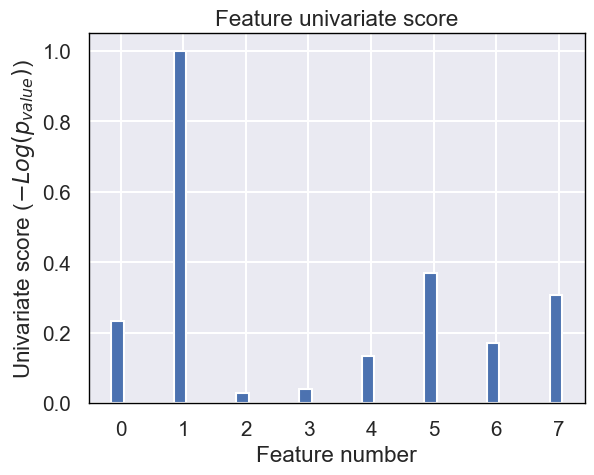

In [56]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=4)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

import matplotlib.pyplot as plt

X_indices = np.arange(X.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

From the total set of features (7), 6 are significant, above the common p-value threshold of 0.05 or 0.01. 

Being these 6 features: Pregnancy, Glucose, Insulin, BMI, Diabetes Pedigree Function and Age. Being Glucose the feature with higher value (p_value of 1), this is because the high amount of glucose on blood is main indivative of having diabetes.

### COMPARISON WITH SVMs

#### Without unvariate feature selection

In [57]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC

clf = make_pipeline(MinMaxScaler(), LinearSVC(dual="auto"))
clf.fit(X_train, y_train)
print(
    "Classification accuracy without selecting features: {:.3f}".format(
        clf.score(X_test, y_test)
    )
)

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

Classification accuracy without selecting features: 0.771


#### With unvariate feature selection

In [58]:
clf_selected = make_pipeline(
    SelectKBest(f_classif, k=4), MinMaxScaler(), LinearSVC(dual="auto")
)
clf_selected.fit(X_train, y_train)
print(
    "Classification accuracy after univariate feature selection: {:.3f}".format(
        clf_selected.score(X_test, y_test)
    )
)

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

Classification accuracy after univariate feature selection: 0.766


#### Analysis of results

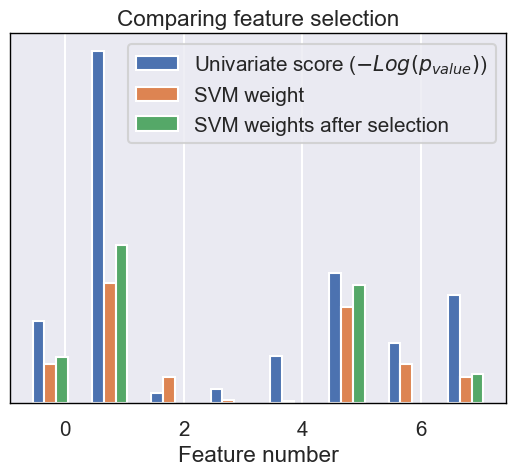

In [59]:
plt.bar(
    X_indices - 0.45, scores, width=0.2, label=r"Univariate score ($-Log(p_{value})$)"
)

plt.bar(X_indices - 0.25, svm_weights, width=0.2, label="SVM weight")

plt.bar(
    X_indices[selector.get_support()] - 0.05,
    svm_weights_selected,
    width=0.2,
    label="SVM weights after selection",
)

plt.title("Comparing feature selection")
plt.xlabel("Feature number")
plt.yticks(())
plt.axis("tight")
plt.legend(loc="upper right")
plt.show()

From the feature selection plot comparison and the accuracies shown after each code block some conclusions can be obtained. 

Without unvariate feature selection, the SVM assigns a large weight to 6 features: Pregnancy, Glucose, Insulin, BMI, Diabetes Pedigree Function and Age. Between these features there are some that are non-informative features. 
By appliying univariate feature selection, after and without a selection, the classification can be improved. 

Applying univariate feature selection before the SVM increases the SVM weight attributed to the significant features, and will thus improve classification. This can be seen for example with Pregnancies, Glucose, BMI and Age features where the SVM weights after selection are higher than the SVM weights calculated without a previous selection. 

Despite this, it can be seen that there are some major changes between both SVM weights and the Univariate score values. 

With these conclusions it could be said that by having a precise feature selection before training a Support Vector Machine, more good results can be obtained according to the Univariate Score on most of the features. 
